# Reservoir model - only output is trained

- Implemented a recurrent reservoir model, see summary(model) below for details on the layers. 
- Performing classification on the Digits dataset from sklearn.
- Results measured in logg loss (sum) and accuracy. 

Questions i still have:
- What parameters should be kept constant? (e.g. learning rate, momentum sgd, batch size ) - are these also considered for evolutionairy optimization? 


In [59]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn import datasets
import numpy as np
import os, sys, tarfile
import requests
import shutil
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
from pytorch_model_summary import summary

### The Digits Dataset:

In [60]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]
        self.transforms = transforms
        self.target_names = digits.target_names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [61]:
# Initiliazing the data loaders for the digits dataset. 

train_data_digits = Digits(mode='train')
val_data_digits = Digits(mode='val')
test_data_digits = Digits(mode='test')

LABELS = train_data.target_names

train_loader_digits = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader_digits = DataLoader(val_data, batch_size=50, shuffle=False)
test_loader_digits = DataLoader(test_data, batch_size=50, shuffle=False)

result_dir = 'results_baseline_wiebe/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

6


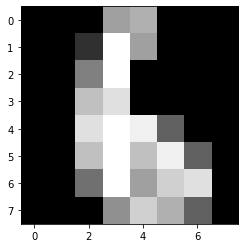

In [62]:
# Print an example digit and its according target label. - (digits dataset)

print(train_data_digits.targets[88])
plottable_image = np.reshape(train_data_digits.data[88], (8, 8))
plt.imshow(plottable_image, cmap='gray')

### The MNIST Dataset:

In [63]:
class MNIST(Dataset):
    """Complete MNIST dataset."""

    def __init__(self, mode='train', transforms=None):
        data_set_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

        data_set_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
        self.data = []
        self.targets = []
        
        if mode == 'train':
            for i in range(40000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        elif mode == 'val':
            for i in range(50000, 60000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        else:
            for i in range(len(data_set_test)):
                self.data.append(data_set_test[i][0].numpy())
                self.targets.append(data_set_test[i][1])
        
        self.targets = np.array(self.targets)
        self.data = np.array(self.data)
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [64]:
# Load in the MNIST dataset - (takes longer to load than Digits!, 6)
train_data_mnist = MNIST(mode='train')
val_data_mnist = MNIST(mode='val')
test_data_mnist = MNIST(mode='test')

train_loader_mnist = DataLoader(train_data_mnist, batch_size=50, shuffle=True)
val_loader_mnist = DataLoader(val_data_mnist, batch_size=50, shuffle=True)
test_loader_mnist = DataLoader(test_data_mnist, batch_size=50, shuffle=True)

1


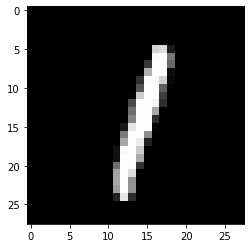

In [65]:
# Print an example MNIST digit and its according target label. - (digits dataset)

print(val_data_mnist.targets[1900])
plottable_image = np.reshape(val_data_mnist.data[1900], (28, 28))
plt.imshow(plottable_image, cmap='gray')

In [66]:
class Reservoir(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size, T, dataset = None):
        super(Reservoir, self).__init__()
        
        # Activation functions
        self.f_0 = nn.Tanh()
        self.f_t = nn.ReLU(inplace=False)
        self.f_y = nn.LogSoftmax(dim=1)
        
        # Amount of timesteps / recurrent layers
        self.T = T
        
        # Initialize the weights & layers
        self.initWeights(input_size, reservoir_size, output_size)
        self.initLayers(input_size, reservoir_size, output_size)
        
        # Boolean
        self.dataset = dataset

    def forward(self, input):
        
        used_input = input
        
        # Squeeze the used input in 2 dims if we use the MNIST dataset.
        if self.dataset == 'MNIST':
            three_d_tensor = used_input.squeeze(1)
            used_input = three_d_tensor.contiguous().view(three_d_tensor.size()[0], -1)  # 28 * 28 pixels = 784
        
        # Calculate c_0
        c = self.f_0(self.layer1(used_input))
        
        for t in range(self.T):
            # c_t =  f_t (W_r * c_t-1 + U * x_t)
            c = self.f_t(self.layer2(c) + self.layer3(used_input))
        
        # Calculate y = f_y ( W_out * c_t)
        y = self.f_y(self.layer4(c))
    
        return y
    
    def initWeights(self, input_size, reservoir_size, output_size):
        
        # Sample the initial weights from a uniform distribution - initialize the same as in the baseline model.
        self.W_in = nn.Parameter(data = torch.zeros(reservoir_size, input_size, requires_grad=False))
        self.W_in.data.uniform_(-0.01, 0.01)
        
        self.W_r = nn.Parameter(data = torch.zeros(reservoir_size, reservoir_size), requires_grad=False)
        self.W_r.data.uniform_(-0.01, 0.01)
        
        self.W_out = nn.Parameter(data = torch.zeros(output_size, reservoir_size), requires_grad=True)
        self.W_out.data.uniform_(-0.01, 0.01)
        
        self.U = nn.Parameter(data = torch.zeros(reservoir_size, input_size), requires_grad=False)
        self.U.data.uniform_(-0.01, 0.01)
        return
    
    def initLayers(self, input_size, reservoir_size, output_size):
        # Input layer
        self.layer1 = torch.nn.Linear(input_size, reservoir_size, bias=True)
        self.layer1.weight = self.W_in
        self.layer1.weight.requires_grad = False
        self.layer1.bias.requires_grad = False
        
        # Recurrent layer
        self.layer2 = torch.nn.Linear(reservoir_size, reservoir_size, bias=True)
        self.layer2.weight = self.W_r
        self.layer2.bias.requires_grad = False
        self.layer3 = torch.nn.Linear(input_size, reservoir_size, bias=True)
        self.layer3.weight = self.U
        self.layer3.bias.requires_grad = False
        
        # Output layer
        self.layer4 = torch.nn.Linear(reservoir_size, output_size, bias=True)
        self.layer4.weight = self.W_out
        self.layer4.bias.requires_grad = True
        return
        

In [67]:
# Function that transforms the tensor output to a predicted target name. 
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i]

# Plot both accuracy as log loss. 
def plot_results(epochs, loss, accuracy):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Results Reservoir - Only output is trained.')
    ax1.set(ylabel='Loss')
    ax2.set(ylabel='Accuracy', xlabel='Epochs')
    
    ax1.plot(epochs, loss)
    ax2.plot(epochs, accuracy)
    

    plt.savefig('results_reservoir.png', bbox_inches='tight')
    #plt.close()


# Concatenating the results of all (64*)batches in the lists, calculating the total accuracy. 
def accuracy(pred_targets_list, gold_targets_list):
    total_correct = 0
    total_amount = 0
    
    zip_list = zip(pred_targets_list, gold_targets_list)
    for pred_targets, gold_targets in zip_list:
        total_correct += (pred_targets == gold_targets).float().sum()
        total_amount += len(pred_targets)
    
    accuracy = 100 * total_correct / total_amount

    return accuracy.item()

# Evaluation -> used for validation and test set. 
def evaluation(val_loader, model, epoch, loss_function):
    
    #Evaluating our performance so far
    model.eval()
    
    # Store all results in a list to calculate the accuracy. 
    pred_target_total_acc = []
    target_total_acc = []
    
    # Initialize counters / c
    loss = 0.
    N = 0.
    
    # Iterating over the validation set batches, acquiring tensor formatted results. 
    for indx_batch, (batch, targets) in enumerate(val_loader):
        output = model.forward(batch)
        pred_targets = np.array([])
        for item in output:
            pred_targets = np.append(pred_targets, categoryFromOutput(item))
        pred_targets = torch.from_numpy(pred_targets).int()
        
        # Calculating loss
        loss_t = loss_function(output, targets.long())
        loss = loss + loss_t.item()
        N = N + batch.shape[0]
        
        #Append the batch result to a list of all results
        pred_target_total_acc.append(pred_targets)
        target_total_acc.append(targets)
    
    # Store the loss corrected by its size
    loss = loss / N   
        
    total_accuracy = accuracy(pred_target_total_acc, target_total_acc)
    print('Epoch: %s - Loss of: %s - Accuracy of: %s' %(epoch, loss,total_accuracy))
    
    return epoch, loss, total_accuracy

In [68]:
def training(model, train_loader, val_loader, num_epochs, optimizer, loss_function, max_loss_iter):    
    
    print('Training started for %s epochs.'  %(num_epochs))
    epochs = []
    accuracy_results = []
    loss_results = []
    best_loss = 10000 # Picking random high number to assure correct functionality
    loss_iter = 0

    torch.autograd.set_detect_anomaly(True)

    for epoch in range(num_epochs):

        # Training
        model.train()
        for indx_batch, (batch, targets) in enumerate(train_loader):

            output = model.forward(batch)

            targets = targets.long()

            loss = loss_function(output, targets)
            
            # Optional print of loss per batch
            #print('Loss in batch %s is: %s' %(indx_batch, loss))
        
            # Perform back prop after each batch
            loss = loss_function(output, targets)
            optimizer.zero_grad()
            loss.backward(retain_graph = True)
            optimizer.step()

        # Perform evaluation after each epoch
        epoch, loss_eval, accuracy_eval = evaluation(val_loader, model, epoch, loss_function)
        epochs.append(epoch)
        accuracy_results.append(accuracy_eval)
        loss_results.append(loss_eval)

        if epoch == 0:
            print('* Saving 1st epoch model *')
            torch.save(model, 'trained_reservoir.model')
            best_loss = loss_eval
        else:
            if loss_eval < best_loss:
                print('* Saving new best model *')
                torch.save(model, 'trained_reservoir.model')
                best_loss = loss_eval
                loss_iter = 0
            else:
                loss_iter += 1

            # If loss has not improved for an arbitrary amount of epochs:
        if loss_iter > max_loss_iter:
            break

    plot_results(epochs, loss_results, accuracy_results)

    return model

    

In [69]:
input_size_digits = 64  # 8 * 8 pixels
input_size_mnist = 784  # 28 * 28 pixels
reservoir_size = 128
n_labels = 10
lr_SGD = 0.0001
momentum_SGD = 0.9
n_epochs = 5
max_loss_iter = 10
batch_size= 50
T = 5

Training started for 5 epochs.
Epoch: 0 - Loss of: 2.255411616734096 - Accuracy of: 34.57143020629883
* Saving 1st epoch model *
Epoch: 1 - Loss of: 2.182545209612165 - Accuracy of: 76.28571319580078
* Saving new best model *
Epoch: 2 - Loss of: 2.1104095458984373 - Accuracy of: 83.14286041259766
* Saving new best model *
Epoch: 3 - Loss of: 2.041295122419085 - Accuracy of: 84.28571319580078
* Saving new best model *
Epoch: 4 - Loss of: 1.973761945452009 - Accuracy of: 86.28571319580078
* Saving new best model *


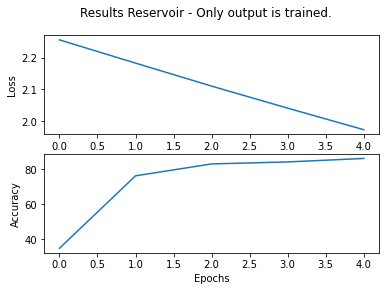

In [70]:
model_digits = Reservoir(input_size_digits, reservoir_size, n_labels, T, dataset = 'Digits')
optimizer_digits = optim.SGD([p for p in model_digits.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
loss_function = nn.NLLLoss(reduction='sum') # Mean is also possible.
trained_model_digits = training(model_digits, train_loader_digits, val_loader_digits, n_epochs, optimizer_digits, loss_function, max_loss_iter)

Training started for 5 epochs.
Epoch: 0 - Loss of: 1.7827579559326172 - Accuracy of: 68.55000305175781
* Saving 1st epoch model *
Epoch: 1 - Loss of: 1.4683156593322755 - Accuracy of: 73.37999725341797
* Saving new best model *
Epoch: 2 - Loss of: 1.2687033664703369 - Accuracy of: 76.41000366210938
* Saving new best model *
Epoch: 3 - Loss of: 1.1341402290344238 - Accuracy of: 78.05999755859375
* Saving new best model *
Epoch: 4 - Loss of: 1.0380381763458253 - Accuracy of: 79.08999633789062
* Saving new best model *


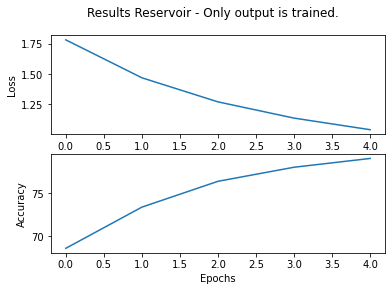

In [71]:
model_mnist = Reservoir(input_size_mnist, reservoir_size, n_labels, T, dataset = 'MNIST')
optimizer_mnist = optim.SGD([p for p in model_mnist.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
loss_function = nn.NLLLoss(reduction='sum') # Mean is also possible.
trained_model_mnist = training(model_mnist, train_loader_mnist, val_loader_mnist, n_epochs, optimizer_mnist, loss_function, max_loss_iter)

In [72]:
print(summary(model_digits, torch.zeros(1, 64), show_input=True, show_hierarchical=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1             [1, 64]           8,320               0
            Tanh-2            [1, 128]               0               0
          Linear-3            [1, 128]          16,512               0
          Linear-4             [1, 64]           8,320               0
            ReLU-5            [1, 128]               0               0
          Linear-6            [1, 128]          16,512               0
          Linear-7             [1, 64]           8,320               0
            ReLU-8            [1, 128]               0               0
          Linear-9            [1, 128]          16,512               0
         Linear-10             [1, 64]           8,320               0
           ReLU-11            [1, 128]               0               0
         Linear-12            [1, 128]          16,512               0
     

In [73]:
test_result_digits = evaluation(test_loader, trained_model_digits, 'Final score Digits', loss_function)

Epoch: Final score Digits - Loss of: 1.9958654143399575 - Accuracy of: 82.32662200927734


In [74]:
test_result_mnist = evaluation(test_loader_mnist, trained_model_mnist, 'Final score MNIST', loss_function)

Epoch: Final score MNIST - Loss of: 1.0466077304840087 - Accuracy of: 78.2699966430664
